# Exact GP playground: Linear Alkanes

In [1]:
%load_ext autoreload
%autoreload 2

import torch
import malt
import abc
import gpytorch

Using backend: pytorch


### Testing GPyTorch API

In [2]:
torch.manual_seed(1)

In [3]:
import torch
import dgl
import malt

from malt.models.regressor import ExactGaussianProcessRegressor
from malt.data.collections import linear_alkanes, esol

# get data
# data = linear_alkanes()
data = esol()
data.shuffle()

# make dataset bigger ....

train_x, train_y = data[:1000].batch()
test_x, test_y = data[1000:].batch()
# train_y /= train_y.max()

# create model
model = malt.models.supervised_model.GaussianProcessSupervisedModel(
    representation=malt.models.representation.DGLRepresentation(
        out_features=32, hidden_features=32,
    ),
    regressor=ExactGaussianProcessRegressor(
        in_features=32,
        out_features=2,
        train_targets=train_y,
    ),
    likelihood=malt.models.likelihood.HeteroschedasticGaussianLikelihood(),
).cuda()

# define marginal log likelihood
from malt.models.marginal_likelihood import ExactMarginalLogLikelihood

mll = gpytorch.mlls.ExactMarginalLogLikelihood(model.regressor.likelihood, model)

# define optimizer
optimizer = torch.optim.Adam([
    {'params': model.parameters()},
], lr=1e-3)

Processing dgl graphs from scratch...
Processing molecule 1000/1128


In [4]:
from tqdm import tqdm
def train(model, optimizer, mll):
    loss_history = []
    train_iter = 100
    model.train()
    for i in tqdm(range(train_iter)):
        # Zero backprop gradients
        optimizer.zero_grad()
        # Get output from model
        output = model(train_x)
        # Calc loss and backprop derivatives
        loss = -mll(output, train_y).mean()
        loss.backward()
        optimizer.step()
        loss_history.append(loss.item())
    return model, loss_history

In [5]:
def test(model, test_x, test_y):
    from scipy.stats import pearsonr
    model.eval()
    with torch.no_grad(), gpytorch.settings.use_toeplitz(False), gpytorch.settings.fast_pred_var():
        preds = model(test_x)
    rmse = torch.sqrt(torch.mean(torch.pow(preds.mean - test_y, 2))).item()
    mae = torch.mean(torch.abs(preds.mean - test_y)).item()
    corr, _ = pearsonr(preds.mean.tolist(), test_y.tolist())
    r2 = malt.metrics.base_metrics.r2(preds.loc, test_y).item()
    return rmse, mae, corr, r2

In [7]:
model.train()
model, loss_history = train(model, optimizer, mll)
model.eval()
with torch.no_grad(), gpytorch.settings.use_toeplitz(False), gpytorch.settings.fast_pred_var():
    preds = model(train_x).loc
rmse, mae, corr, r2 = test(model, test_x, test_y)
print('rmse:', rmse, '\nmae:', mae, '\ncorr:', corr, '\nr2:', r2)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 22.81it/s]


rmse: 0.6207467913627625 
mae: 0.45676758885383606 
corr: 0.9634070817585095 
r2: 0.9267905354499817


Text(0.5, 1.0, 'gpytorch: training')

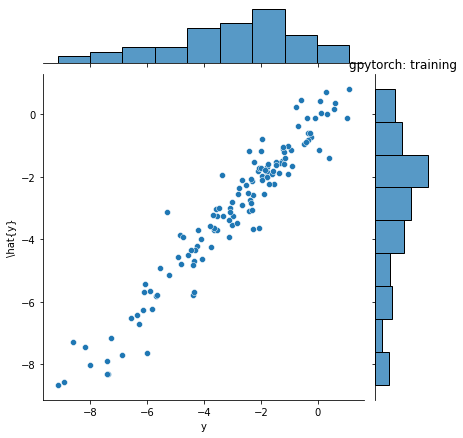

In [8]:
import matplotlib.pyplot as plt

model.eval()

import seaborn as sns

preds = model(test_x)

g = sns.jointplot(x = test_y.ravel().tolist(), y = (preds.loc).tolist())
g.set_axis_labels('y', '\hat{y}')
plt.title('gpytorch: training')

### Testing hard-coded API

In [26]:
model = malt.models.supervised_model.GaussianProcessSupervisedModel(
    representation=malt.models.representation.DGLRepresentation(
        out_features=32, hidden_features=32,
    ),
    regressor=malt.models.regressor.HardcodedExactGaussianProcessRegressor(
        train_targets=train_y,
    ),
    # likelihood=malt.models.likelihood.HeteroschedasticGaussianLikelihood(),
).cuda()

In [27]:
# define marginal log likelihood
from malt.models.marginal_likelihood import HardcodedExactMarginalLogLikelihood

mll = HardcodedExactMarginalLogLikelihood(model.likelihood, model)

# define optimizer
optimizer = torch.optim.Adam([
    {'params': model.parameters()},
], lr=1e-3)

In [31]:
model, loss_history = train(model, optimizer, mll)
model.eval()
with torch.no_grad(), gpytorch.settings.use_toeplitz(False), gpytorch.settings.fast_pred_var():
    preds = model(test_x).loc
rmse, mae, corr, r2 = test(model, test_x, test_y)
print('rmse:', rmse, '\nmae:', mae, '\ncorr:', corr, '\nr2:', r2)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 18.96it/s]


rmse: 0.7730870246887207 
mae: 0.5155682563781738 
corr: 0.943638001871339 
r2: 0.8864479064941406


In [29]:
model(test_x)

MultivariateNormal(loc: torch.Size([128]), covariance_matrix: torch.Size([128, 128]))

In [19]:
model.regressor.train_targets.shape

torch.Size([1000])

In [13]:
model.representation(test_x).shape

torch.Size([128, 32])

In [14]:
model.eval()
model(test_x)

MultivariateNormal(loc: torch.Size([128]), covariance_matrix: torch.Size([128, 128]))

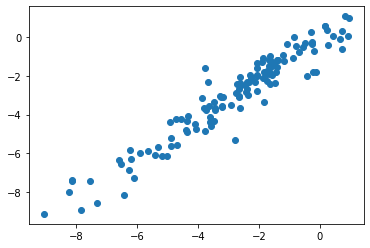

In [15]:
model.eval()
import matplotlib.pyplot as plt

plt.scatter(
    model(test_x).loc.tolist(),
    test_y.tolist(),
)